# Visualizing hyperband-optimization: Connecting HpBandSter and CAVE

In this notebook, we present an example on how to connect our tools <a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> and <a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a> to efficiently optimize a neural network and subsequently analyze and visualize the optimization process.

## About the frameworks

### HpBandSter

<a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a> (HyperBand on Steroids) implements recently published methods for optimizing hyperparameters of machine learning algorithms. One of the implemented algorithms is <a href="https://automl.github.io/HpBandSter/build/html/optimizers/bohb.html" target="_blank">BOHB</a>, combining Bayesian Optimization and HyperBand to efficiently search for well performing configurations. Learn more about this method by reading our paper, published at <a href="http://proceedings.mlr.press/v80/falkner18a.html" target="_blank">ICML 2018</a>.

### CAVE

<a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> (Configuration Assessment, Visualization and Evaluation) is designed to create comprehensive reports about an optimization process. The resulting figures and interactive plots can be used to gain insights in the parameter importance, feature importance, search behaviour and quality. Learn more about CAVE from <a href="https://www.ml4aad.org/algorithm-analysis/cave/" target="_blank">our paper</a>.

### Installation requirements

You need to install HpBandSter and CAVE to run this example. Both can be installed using pip (i.e. `pip install cave hpbandster`).

## Running BOHB

### 1.1) Define a configuration space

Every problem needs a description of the search space to be complete. In HpBandSter, a ConfigurationSpace-object defines all hyperparameters, their ranges and dependencies between them.

In our example here, the search space consists of the hyperparameters:

|         Name        |     Type    |      Values      |     Condition    |
|:-------------------:|:-----------:|:----------------:|:----------------:|
| activation-function | categorical | {'relu', 'tanh'} |                  |
|    learning-rate    |    float    |   [1e-6 - 1e-2]  |                  |
|        solver       | categorical |  {'sgd', 'adam'} |                  |
|        beta_1       |    float    |      [0, 1]      | solver == 'adam' |
|        beta_2       |    float    |      [0, 1]      | solver == 'adam' |

### 1.2) Function to optimize:

To perform a BOHB run on the local machine, we use its new ``f_min`` interface.
It starts a local BOHB optimization run for the function to optimize over the given ``ConfigSpace``, which is described below.

The ``f_min`` interface helps you to run BOHB fast by initialize the core elements of BOHB automatically. If you need more control, for example if you like to run it on your Cluster, we would like to refer you to the <a href="https://automl.github.io/HpBandSter/" target="_blank">more detailed documentation of BOHB</a>. 

To use the ``f_min`` interface, your function must statisfy the follwoing requirements:

- Contain a parameter ``budget``
- take as arguments all of the in the configuration space defined hyperparameters
- return a single python scalar: the objective to minimize of your model,

More information about using ``f_min`` is provided in the 
<a href="https://github.com/automl/BOHBsCAVE/blob/master/EasyOpt.py" target="_blank">f_min documentation</a>.

Both, the configuration space and the function to optimize are moved to example_mlp_on_digits, to increase readability of this notebook.

**Note**:
For later analysis it is crucial to save the configuration space to file. For example with ConfigSpace's <a href="https://automl.github.io/ConfigSpace/master/API-Doc.html#module-ConfigSpace.read_and_write.json" target="_blank">json-serializer</a>. ``f_min`` will do this job automatically for you. But keep it in mind, if you are using the standard BOHB interface.


In [1]:
from example_mlp_on_digits import optimize_mlp_on_digits, get_configspace, load_digits

### 1.3) Starting the optimization run

**NOTE:** While running the optimization proces via ``f_min``, the configuration space as well as the results, obtained by BOHB, are stored to file. This is necessary for the analysis of the run with CAVE.

We read in the configuration space and make a directory to store the results

In [2]:
import os

# Load the configuration space
config_space = get_configspace()

# Create a output directory
out_dir = 'example_mlp_on_digits'
os.makedirs(out_dir, exist_ok=True)

# Load MNIST data
train, valid = load_digits()

We deactivate logging to ensure readability

In [3]:
import logging
logging.basicConfig(level=logging.ERROR)

We suppress warnings, too.
If there are problems for you executing this notebook, you might want to comment this out.

**Let's start the optimiziation run**:

In [5]:
import warnings
from FMin import f_min

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    inc_value, inc_cfg, result = f_min(
        optimize_mlp_on_digits, config_space, func_args=(train, valid),
        eta=2, min_budget=5, max_budget=100, num_iterations=2,
        num_workers=1, output_dir=out_dir)

Besides the best found configuration and its loss value, ``f_min`` returns a Result-object generated by HpBandSter.
The <a href="https://automl.github.io/HpBandSter/build/html/core/result.html" target="_blank">Result-object</a> offers access to basic statistics, as well as the trajectory.

In [6]:
id2config = result.get_id2config_mapping()
incumbent_trajectory = result.get_incumbent_trajectory()

print('A total of {} unique configurations where sampled.\n'
      'A total of {} runs where executed.\n'
      'Best configuration found: {}'.format(
      len(id2config.keys()), 
      len(result.get_all_runs()), 
      id2config[result.get_incumbent_id()]['config']))

A total of 24 unique configurations where sampled.
A total of 46 runs where executed.
Best configuration found: {'activation': 'tanh', 'learning_rate_init': 0.0036172364041937174, 'solver': 'adam', 'beta_1': 0.7415885379119607, 'beta_2': 0.975421591502096}


The ``incumbent trajectory`` is a dictionary with all the configuration IDs,
the times the runs finished, their respective budgets,
and corresponding losses. It's used to do meaningful plots of the optimization process.

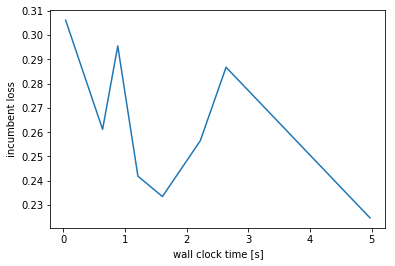

In [7]:
import matplotlib.pyplot as plt

plt.plot(incumbent_trajectory['times_finished'], incumbent_trajectory['losses'])
plt.xlabel('wall clock time [s]')
plt.ylabel('incumbent loss')
plt.show()

## Using the results in CAVE

### 2.1) Creating a HTML-report with CAVE

Creating the report with CAVE is very straight-forward. Simply provide the output-directory of the BOHB-analysis in CAVE's `--folders` argument and specify `--file_format` as `BOHB`. You can do this by commandline ('!' simply executes the command as if it was executed on the command line):


In [ ]:
! cave --folders example_mlp_on_digits --file_format BOHB --output CAVE_bash_mlp_on_digits --verbose_level OFF

After CAVE finished the report, you can have a look at it with your favorite browser.

In [ ]:
! firefox ./CAVE_bash_mlp_on_digits/report.html

### 2.2) Using CAVE from within Python

Of course you can use CAVE on a module-level. Import and instantiate it (very similarily to the commandline). By default, CAVE even outputs all analysis results in a jupyter-cell-compatible way. Of course, the HTML-report is built meanwhile, so you don't have to run time-consuming analyzing-methods repeatedly.

In [ ]:
from cave.cavefacade import CAVE

cave = CAVE(folders=["example_mlp_on_digits"],
            output_dir="CAVE_python_mlp_on_digits",
            ta_exec_dir=["."],
            file_format='BOHB',
            verbose_level='OFF'
           )

The most interesting plot for BOHB might be a visualization of the learning curves:

In [ ]:
cave.bohb_learning_curves()

We can access the individual budgets via the 'run'-keyword-argument of each analysis-method.

In [ ]:
cave.overview_table(run='budget_12.5')

For each budget, we can list the cost over incumbents:

In [ ]:
cave.bohb_incumbents_per_budget()

In [ ]:
cave.performance_table(run='budget_25.0')

For parameter-importance analysis, CAVE uses <a href="https://github.com/automl/ParameterImportance" target="_blank">PIMP</a> , a package that provides multiple approaches to parameter-importance analysis. We can easily invoke them via CAVE, of course. To estimate the importance, random forests are used to predict performances of configurations that were not executed. This is difficult for big budgets with few configurations.

In [ ]:
cave.cave_fanova(run='budget_12.5')

In [ ]:
cave.cave_ablation(run='budget_12.5')

In [ ]:
cave.local_parameter_importance(run='budget_12.5')

In [ ]:
cave.pimp_forward_selection(run='budget_12.5')

For each budget, we can compare the different parameter-importance-methods that have already been run:

In [ ]:
cave.pimp_comparison_table(run='budget_12.5')

To analyze BOHB's behaviour, we can check out the configurator footprint, cost-over-time and parallel coordinated parameters:

In [ ]:
cave.configurator_footprint(run='budget_12.5', use_timeslider=True, num_quantiles=5)

In [ ]:
cave.cost_over_time(run="budget_25.0")

In [ ]:
cave.parallel_coordinates(run='budget_12.5')